# HaccyTrees

In [1]:
import haccytrees.mergertrees
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

pyfftw not available, using numpy fft


In [2]:
# New files, 1/26/2021
forest, progenitor_array = haccytrees.mergertrees.read_forest('/data/a/cpac/mbuehlmann/LastJourney/forest/m000p.forest.000.hdf5',
                                                              'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11)

### Establish Globals

In [4]:
n = 10
snap = 100
thresholds = [5*10**11] # [1/10, 0.3]
thresholds_are_absolute = True
norm = np.int(2.7*10**9)
xaxis = 'z_nums'
my_range = [10**13, 10**14]
my_range_str = ["{:.2e}".format(my_range[0]), "{:.2e}".format(my_range[1])]
rangel_bins = [1*10**11, 1.5*10**11, 2.3*10**11, 3.5*10**11, 5.3*10**11, 8.1*10**11, 1.2*10**12, 1.9*10**12, 2.8*10**12, 4.3*10**12, 6.6*10**12, 1*10**13]
rangel_bins2 = np.concatenate(([rangel_bins[0] - 0.25*10**11], [(rangel_bins[i] + rangel_bins[i+1]) / 2 for i in np.arange(len(rangel_bins) -1)], [rangel_bins[-1] + 3.4*10**13]), axis = 0)
norm_tf = True
avg_tf = True
# Convert snapshots to redshifts -- opposite order (chronological)
redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))
mass_fof = np.array(forest['fof_halo_mass'])
mass_fof[forest['snapnum'] == 100]

array([3.2337016e+11, 3.1250055e+11, 5.0271830e+11, ..., 5.5978361e+11,
       3.1521797e+11, 4.1059856e+12], dtype=float32)

## Make bins (equally distributed)

In [14]:
# Apparently the idea of equal distribution will depend on whether you are making a histogram or a pdf... I think in our case we want something closer to equally distributed histogram?
# Find the total number of targets in the range. Divide that into three. Then somehow find the threshold that reaches the count for the first third, and then the second third
mbins = [1e13, 1e14]
target_idx = help_func_haccytrees.find_halos(forest, mbins)
onethird = int(len(target_idx)/3)
target_idx_sorted = target_idx[np.argsort(forest['tree_node_mass'][target_idx])]
mask = np.isin(target_idx, target_idx_sorted)

[    4686    10389    12569 ... 64121491 64122063 64125616]
41428
[1.0000018e+13 1.0000018e+13 1.0000018e+13 ... 9.9943117e+13 9.9956707e+13
 9.9989313e+13]
[36387 13286 10309 ... 28555 30881 18867]


41428

### Testing HaccyTrees

In [47]:
z0_mask = forest['snapnum'] == 100
mlim = [1e13, 2e13]
target_mask = z0_mask & (forest['fof_halo_mass'] > mlim[0]) * (forest['fof_halo_mass'] < mlim[1])
target_idx = forest['halo_index'][target_mask]

# this will create a matrix of shape (ntargets, nsteps), where each column
# is the main progenitor branch of a target. It contains the indices to the
# forest data, and is -1 if the halo does not exist at that time
mainbranch_index = haccytrees.mergertrees.get_mainbranch_indices(
    forest, simulation='LastJourney', target_index=target_idx
)

# Get the mass of the main branches
active_mask = mainbranch_index != -1
mainbranch_mass = np.zeros_like(mainbranch_index, dtype=np.float32)
mainbranch_mass[active_mask] = forest['fof_halo_mass'][mainbranch_index[active_mask]]

### Find some good target indices to test

In [48]:
active_mainbranch = [mainbranch[np.where(mainbranch != -1)] for mainbranch in mainbranch_index]
lengths = np.array([len(mainbranch) for mainbranch in active_mainbranch])
active_mainbranch[np.argmax(lengths)]

array([1321244, 1321243, 1321242, 1321241, 1321240, 1321239, 1321238,
       1321237, 1321236, 1321235, 1321234, 1321233, 1321232, 1321231,
       1321230, 1321229, 1321228, 1321227, 1321226, 1321225, 1321224,
       1321223, 1321222, 1321221, 1321220, 1321219, 1321218, 1321217,
       1321216, 1321215, 1321214, 1321213, 1321212, 1321211, 1321210,
       1321209, 1321208, 1321207, 1321206, 1321205, 1321204, 1321203,
       1321202, 1321201, 1321200, 1321199, 1321198, 1321197, 1321196,
       1321195, 1321194, 1321193, 1321192, 1321191, 1321190, 1321189,
       1321188, 1321187, 1321186, 1321185, 1321184, 1321183, 1321182,
       1321181, 1321180, 1321179, 1321178, 1321177, 1321176, 1321175,
       1321174, 1321173, 1321172, 1321171, 1321170, 1321169, 1321168,
       1321167, 1321166, 1321165, 1321164, 1321163, 1321162, 1321161,
       1321160, 1321159, 1321158, 1321157, 1321156, 1321155, 1321154,
       1321153, 1321152, 1321151, 1321150, 1321149, 1321148, 1321147,
       1321146, 1321

#### Re-Find a halo from a different run

In [ ]:
# Find the tree node index using your old halo index
forest['tree_node_index'][1321144]

Re-run your `read_forest()` now

In [102]:
# Find the *new* indices associated with that tree node index
a = np.nonzero(forest['tree_node_index'] == 2247296214057904797)[0] # Index so it's not a generator
# Find whatever variable you want
forest['tree_node_mass'][a]
# I'm still not sure how you can just get all the variables associated with halo_index = a

array([1.5763615e+13], dtype=float32)

In [90]:
# This works too, but not as useful
np.where(forest['tree_node_index'] == 2247296214057904797)

(array([1321144]),)

### Find main branch of just one halo

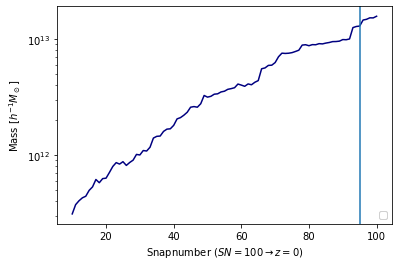

In [167]:
target_idx = 253422
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
xaxis = 'snap_nums'
mainbranch_mass
timesteps = np.linspace(0, 100, 101)
fig, ax = help_func_haccytrees.plot_evol([mainbranch_mass[0]], x_axis = xaxis)
ax.axvline(x=95) # LMM

In [101]:
#fig.savefig("haccytrees_mass_evol_nothresh.png")
fig.savefig("haccytrees_mass_evol_new.png")

### Get Main Branches for multiple halos

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Snapnumber $(SN = 100 \\rightarrow z = 0)$', ylabel='Mass $[h^{-1}M_\\odot]$'>)

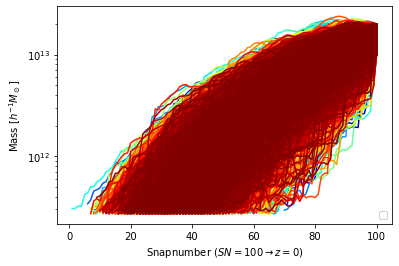

In [103]:
mbins = [1e13, 2e13]
target_idx = help_func_haccytrees.find_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
xaxis = 'snap_nums'
help_func_haccytrees.plot_evol(mainbranch_mass, x_axis = xaxis)

### Get Main Branches for binned halos

37079


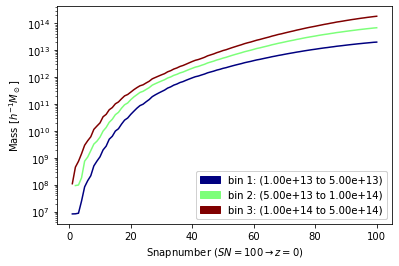

In [88]:
#mbins = [1e12, 5e12, 1e13, 5e13, 1e14, 5e14]
mbins = [1e13, 5e13, 1e14, 5e14]
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
print(len(target_idx[0]))
mainbranch_binned_index, mainbranch_binned_masses = help_func_haccytrees.get_binned_branches(target_idx, forest, snap = 100)
mainbranch_avg_masses = help_func_haccytrees.avg_mass_bins(mainbranch_binned_masses, mbins)
xaxis = 'snap_nums'
fig, ax = help_func_haccytrees.plot_evol(mainbranch_avg_masses, bins = mbins, avg = True, x_axis = xaxis)

In [38]:
fig.savefig("haccy_mass_evol_binned.png")

## Mass Growth Rates

#### Single Bin

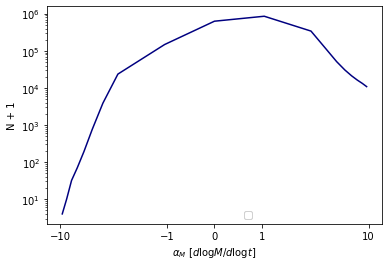

In [108]:
mbins = [1e13, 1e14]
target_idx = help_func_haccytrees.find_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
# Calculate the alphas
alphas = help_func_haccytrees.calc_mass_growth_rate(mainbranch_mass)
# Plot them
a = help_func_haccytrees.plot_mass_growth_rates([alphas], n_hist_bins = 20, zoom = True, log = True)
#alphas

#### Multiple bins

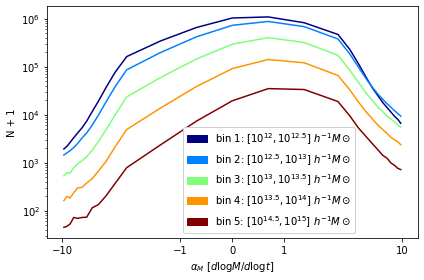

In [109]:
mbins = [1e12, 10**12.5, 1e13, 10**13.5, 1e14, 10**14.5]
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches_binned(target_idx, forest)
alphas = help_func_haccytrees.calc_mass_growth_rate_binned(mainbranch_mass)
bin_labels = [r"$[10^{12}, 10^{12.5}]$ $h^{-1}M\odot$", r"$[10^{12.5}, 10^{13}]$ $h^{-1}M\odot$", r"$[10^{13}, 10^{13.5}]$ $h^{-1}M\odot$", r"$[10^{13.5}, 10^{14}]$ $h^{-1}M\odot$", r"$[10^{14.5}, 10^{15}]$ $h^{-1}M\odot$"]
fig, ax = help_func_haccytrees.plot_mass_growth_rates(alphas, bin_labels = bin_labels, n_hist_bins = 30, zoom = True, log = True)
fig.tight_layout()

This shape looks much better when we use the `mass_threshold` condition in `read_forest()`! Probably because we don't have so many poorly resolved halos, messing with statistics. (Why would having more poorly resolved halos cause this alpha distribution plot to look different? Specifically, slightly too high on the LHS?) 

In [36]:
fig.savefig("haccy_mass_growth_rates.png")

## Main Branch Lengths

In [47]:
# New way
mbins = rangel_bins2
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
xaxis = 'z_nums'
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches_binned(target_idx, forest)

/data/a/cpac/aurora/fossil_groups/help_func_haccytrees.py:566: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  def plot_main_branch_length_new(mp_list, n_bins = 32, hist_bins = [], zoom = False, log = True, dist_or_hist = 'dist'):


CPU times: user 38.4 s, sys: 1.37 s, total: 39.8 s
Wall time: 39.8 s


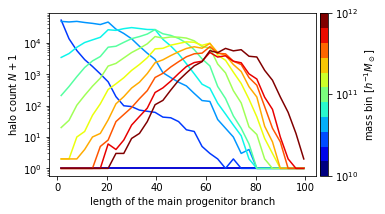

In [56]:
fig, ax = help_func_haccytrees.plot_main_branch_length(mainbranch_index, hist_bins = rangel_bins, log = True)

Wow! That `mass_threshold` makes a big difference to this plot! (really, it should affect everything up to the yellow branches). Also, the "crossing point" (where the different colors seem to cross each other on the RHS) appears lower, looser, and more spread (to the left)

In [9]:
fig.savefig("full_haccy_main_branch_lengths.png")

In [7]:
#main_prog_list = [[prog_id for prog_id in np.flip(this_bin_idx) if prog_id != -1] for this_bin_idx in mainbranch_index]
main_prog_list = []
for this_bin_idx in mainbranch_index:
    bins = []
    for this_halo in np.flip(this_bin_idx):
        halos = []
        for prog_id in this_halo:
            if prog_id != -1:
                halos.append(prog_id)
        bins.append(halos)
    main_prog_list.append(bins)
# need to do this for each bin, each halo, each index
# Why are you crashing???

## Major Merger Stats

#### Single Halo

In [164]:
# Old version
target_idx = 253422
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mergers, mergers_index, LMM = help_func_haccytrees.get_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold, major_mergers_only, merger_threshold)
print(mergers)
print(mergers_index)
print(LMM)

[3.5869629e+11 8.6413201e+11 3.5254639e+11 4.7633036e+11 2.0516341e+12
 1.4062149e+12]
[253513 253521 253548 253559 253578 253640]
253640


In [166]:
forest['snapnum'][253640]

95

#### Single mass bin

In [176]:
mbins = [1e13, 1e14]
target_idx = help_func_haccytrees.find_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)

# Now find major mergers
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mergers, mergers_index = help_func_haccytrees.get_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold, major_mergers_only, merger_threshold)
print(mergers)
print(mergers_index)

[0. 0. 0. ... 0. 0. 0.]
[3.3423973e+11 2.2880476e+12 4.3944853e+12 ... 9.2663212e+11 1.3280029e+12
 2.9480245e+12]
[    4749     4764     4818 ... 64125678 64125695 64125728]


In [105]:
forest['tree_node_mass'][64125728]

2948024500000.0

#### Multiple bins

In [177]:
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mbins = [1e13, 5e13, 1e14, 5e14]
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
mainbranch_binned_index, mainbranch_binned_masses = help_func_haccytrees.get_branches_binned(target_idx, forest, snap = 100)
binned_mergers, binned_mergers_index = help_func_haccytrees.get_mergers_binned(forest, progenitor_array, mainbranch_binned_index, absolute_threshold, major_mergers_only, merger_threshold)

[0. 0. 0. ... 0. 0. 0.]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.2065274e+11 0.0000000e+00
 0.0000000e+00]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.8882839e+12
 0.0000000e+00]


In [120]:
a = b = []
print(a, " ", b)
a = 5
print(a, " ", b)
# Why does this work fine, but trying the same thing for mergers and merger indices didn't?

[]   []
5   []


#### Example version

## LMM Stats

#### Single mass bin

[2.22044605e-16 4.37433155e+00 5.77708006e-01 ... 1.05521472e+00
 1.54430380e+00 5.39050536e-01]
bin_n:  0


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'PDF of Last Luminous Mergers in range: 1.0e+13 to 2.0e+13'}, xlabel='Redshift of LMM', ylabel='Probability'>)

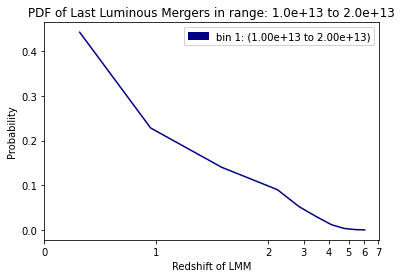

In [152]:
# Runs for a single bin, not so much for multiple bins. Weirdly looks way better for absolute criterion rather than relative?
mbins = [1e13, 2e13]
absolute_threshold = False
threshold = 0.3
target_idx = help_func_haccytrees.find_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
lmms = help_func_haccytrees.get_lmms(mainbranch_mergers, threshold) # When we don't include the last line, we get the same result as lmms[lmms > 0]
print(lmms)
#print(lmms[lmms < 0]) # ah yes... looks like there's lots of -1s!
help_func_haccytrees.plot_LMMs([lmms[lmms > 0]], bins = mbins, mass_range = mbins, x_axis = xaxis) # Would be cool if this could do pdfs AND cdfs, or at least specify

#### Multiple Bins

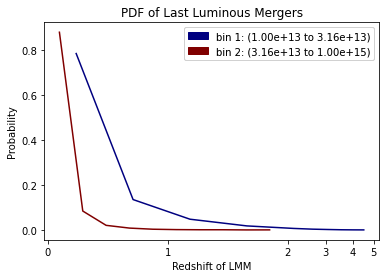

In [34]:
#Weirdly looks way better for absolute criterion rather than relative?
mbins = [1e13, 10**13.5, 1e15] #[10**11.5, 10**12.5, 10**13.5, 10**14.5]
absolute_threshold = True
threshold = 5e11
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
binned_mainbranch_index, binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(target_idx, forest)
binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(forest, progenitor_array, binned_mainbranch_index, absolute_threshold)
binned_lmms = help_func_haccytrees.get_binned_lmms(binned_mainbranch_mergers, threshold)
fig, ax = help_func_haccytrees.plot_LMMs(binned_lmms, bins = mbins, x_axis = xaxis) # Would be cool if this could do pdfs AND cdfs, or at least specify

In [263]:
fig.savefig("haccy_pdf_llms_absolute.png")

<bound method Figure.tight_layout of <Figure size 432x288 with 1 Axes>>

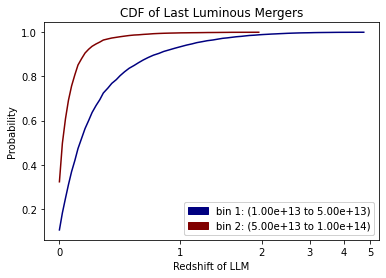

In [16]:
fig,ax = help_func_haccytrees.plot_CDF(binned_lmms, bins = mbins)
fig.tight_layout

In [14]:
fig.savefig("haccy_cdf_llms_absolute.png")

#### Cumulative mean number of major mergers

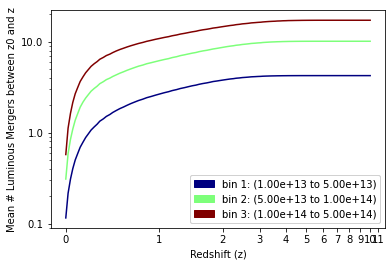

In [61]:
mbins = [1e13, 5e13, 1e14, 5e14] #[10**11.5, 10**12.5, 10**13.5, 10**14.5]
absolute_threshold = True
threshold = 5e11
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
binned_mainbranch_index, binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(target_idx, forest)
binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(forest, progenitor_array, binned_mainbranch_index, absolute_threshold)
binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers, threshold)
binned_avg_cum_mms = help_func_haccytrees.long_calc_binned_avg_cum_mms(binned_major_mergers)
fig, ax = help_func_haccytrees.plot_cum_mms(binned_avg_cum_mms, mbins)

Notice, none of these plots cross the x-axis. They did in LJSV -- probably because there were fewer groups.

In [54]:
fig.savefig('haccy_cum_lms.png')

#### Testing Michael's Examples

In [67]:
z0_mask = forest['snapnum'] == 100
mlim = [1e13, 2e13]
target_mask = z0_mask & (forest['tree_node_mass'] > mlim[0]) & (forest['tree_node_mass'] < mlim[1])
target_idx = forest['halo_index'][target_mask]

# this will create a matrix of shape (ntargets, nsteps), where each column
# is the main progenitor branch of a target. It contains the indices to the
# forest data, and is -1 if the halo does not exist at that time
mainbranch_index = haccytrees.mergertrees.get_mainbranch_indices(
    forest, simulation='LastJourney', target_index=target_idx
)

# Get the mass of the main branches
active_mask = mainbranch_index != -1
mainbranch_mass = np.zeros_like(mainbranch_index, dtype=np.float32)
mainbranch_mass[active_mask] = forest['tree_node_mass'][mainbranch_index[active_mask]]

In [68]:
main_progenitor_index = haccytrees.mergertrees.get_nth_progenitor_indices(
    forest, progenitor_array, target_index=mainbranch_index[active_mask], n=1
)

# get indices to secondary progenitors (main mergers)
main_merger_index = haccytrees.mergertrees.get_nth_progenitor_indices(
    forest, progenitor_array, target_index=mainbranch_index[active_mask], n=2
)

# the index will be negative if there's no merger, mask those out
merger_mask = main_merger_index >= 0

# allocate a merger_ratio matrix, 0 by default
merger_ratio = np.zeros_like(mainbranch_index, dtype=np.float32)

# fill the elements for which a merger occurred with the mass ratio
merger_ratio[tuple(np.argwhere(active_mask)[merger_mask].T)] = forest['tree_node_mass'][main_merger_index[merger_mask]] / forest['tree_node_mass'][main_progenitor_index[merger_mask]]

In [69]:
# get indices to secondary progenitors (main mergers)
main_merger_index = haccytrees.mergertrees.get_nth_progenitor_indices(
    forest, progenitor_array, target_index=mainbranch_index[active_mask], n=2
)

# the index will be negative if there's no merger, mask those out
merger_mask = main_merger_index >= 0

# allocate an array containing the merger masses, 0 by default
merger_mass = np.zeros_like(main_merger_index, dtype=np.float32)

# fill the elements for which a merger occurred with the mass of the main merger
merger_mass[merger_mask] = forest['tree_node_mass'][main_merger_index[merger_mask]]

In [70]:
simulation = haccytrees.Simulation.simulations['LastJourney']
scale_factors = simulation.step2a(np.array(simulation.cosmotools_steps))
last_snap = len(simulation.cosmotools_steps) - 1

# allocate an array containing merger info for each halo at the appropriate snapshot
mainbranch_merger = np.zeros_like(mainbranch_index, dtype=np.float32)

# with a relative threshold
threshold = 0.3 # or whatever
mainbranch_merger[tuple(np.argwhere(active_mask)[merger_mask].T)] = forest['tree_node_mass'][main_merger_index[merger_mask]] / forest['tree_node_mass'][main_progenitor_index[merger_mask]]
last_mm_index = last_snap - np.argmax((mainbranch_merger > threshold)[:, ::-1], axis=1)

# with an absolute threshold
#threshold = 7e12 # or whatever
#mainbranch_merger[tuple(np.argwhere(active_mask)[merger_mask].T)] = forest['tree_node_mass'][main_progenitor_index[merger_mask]]
#last_mm_index = last_snap - np.argmax((mainbranch_merger > threshold)[:, ::-1], axis=1)

last_mm_redshift = 1/scale_factors[last_mm_index] - 1

# Fossil Group Stats (!)

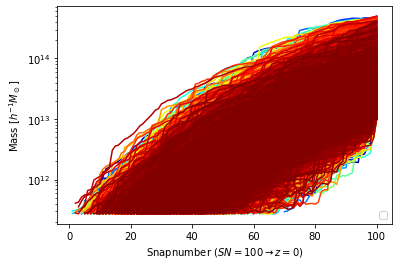

In [12]:
#mbins = [1e13, 5e13, 1e14, 5e14]
mbins = [1e13, 5e14]
xaxis = 'snap_nums'
absolute_threshold = True
threshold = 5e11
z_thresh = 1
# Go find yourself some fossil groups!
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
binned_mainbranch_index, binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(target_idx, forest)
binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(forest, progenitor_array, binned_mainbranch_index, absolute_threshold)
fig1, ax1 = help_func_haccytrees.plot_evol(binned_mainbranch_masses[0], x_axis = xaxis) 

In [13]:
# Find FGs
binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers, threshold)
binned_lmm_redshift, binned_lmm_index = help_func_haccytrees.get_binned_lmms(binned_major_mergers, threshold)
binned_fgs = help_func_haccytrees.find_binned_fossils(forest, binned_lmm_redshift, target_idx, z_thresh)
# Notice we are using the original target_idx -- that will connect back to halo_index's

In [21]:
print(len(binned_fgs[0][0]))

2324


In [6]:
# Now, analyze these new fg candidates!
xaxis = 'snap_nums'
fg_target_idx = binned_fgs[1] # Test one bin at a time
fg_binned_mainbranch_index, fg_binned_mainbranch_masses = help_func_haccytrees.get_branches(fg_target_idx, forest)
fig, ax = help_func_haccytrees.plot_evol(fg_binned_mainbranch_masses, x_axis = xaxis)
fig.savefig("fgs_evol.png")

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/haccytrees/mergertrees/forest_reader.py:296: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  target_index = np.array(target_index)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 1d, C)
During: typing of argument at /home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/haccytrees/mergertrees/forest_reader.py (253)

File "../../../../../home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/haccytrees/mergertrees/forest_reader.py", line 253:
def _get_mainbranch(snapnum, target_indices, mainbranch_matrix):
    ntargets = len(target_indices)
    ^


#### Trying bin stats again

/home/acossairt/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/acossairt/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Snapnumber $(SN = 100 \\rightarrow z = 0)$', ylabel='Mass $[h^{-1}M_\\odot]$'>)

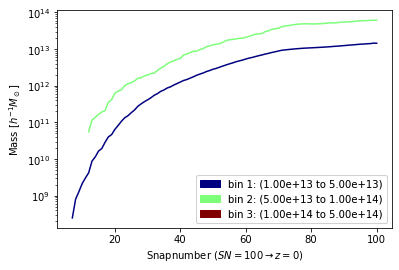

In [68]:
fg_target_idx = binned_fgs
fg_binned_mainbranch_index, fg_binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(fg_target_idx, forest)
mainbranch_avg_masses = help_func_haccytrees.avg_mass_bins(fg_binned_mainbranch_masses, mbins)
xaxis = 'snap_nums'
help_func_haccytrees.plot_evol(mainbranch_avg_masses, bins = mbins, avg = True, x_axis = xaxis)

### Old way (back when I was using halo id of lmm)

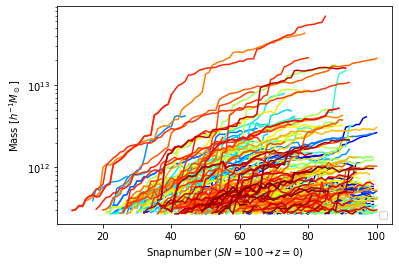

In [15]:
target_idx = binned_fgs[0]
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
xaxis = 'snap_nums'
fig, ax = help_func_haccytrees.plot_evol(mainbranch_mass, x_axis = xaxis)
fig.savefig("fg_evols.png")

Hmm... seems to be looking at all branches, not just the main ones (that end at z = 0)

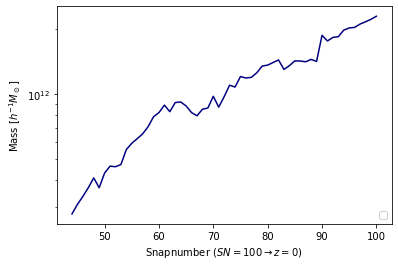

In [38]:
target_idx = 26451 #26452 #26478 #26479
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
xaxis = 'snap_nums'
mainbranch_mass
timesteps = np.linspace(0, 100, 101)
fig, ax = help_func_haccytrees.plot_evol([mainbranch_mass[0]], x_axis = xaxis)
ax.axvline(x=binned_lmm_index[0][target_idx]) # LMM

In [ ]:
new_binned_fgs = help_func_haccytrees.find_binned_fossils(forest, binned_lmm_redshift, z_thresh)
new_binned_fgs

### Check overall average mass evolution|

In [69]:
def getsubsampleindex(npoints,datalength):
    index=np.asarray([])
    if(datalength>0):
        sample=np.random.sample(datalength)
        fraction=min(float(npoints)/float(datalength),1.0)
        index=(sample<fraction)
    return index

Text(0.5, 1.0, 'Mass evolution of halos in bin 1: $[10^{13}, 10^{13.5}]$ $h^{-1}M_\\odot$')

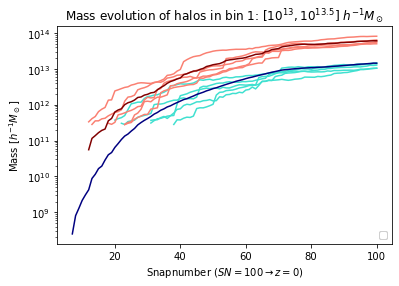

In [145]:
# Samples and averages
fg_idx = binned_fgs[0:2]
N = 5
fig = None
ax = None
xaxis = 'snap_nums'
# First, plot some samples
color = iter(["turquoise", "salmon"])
for halo_idx in fg_idx: # For each of the lower two bins (last one is empty)
    current_color = next(color)
    sampled_idx = np.random.choice(halo_idx, N, replace=False)
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(sampled_idx, forest)
    # Plot them
    fig, ax = help_func_haccytrees.plot_evol(mainbranch_masses, x_axis = xaxis, fig = fig, ax = ax, cust_color = current_color)

# Now, find the averages
mbins = [1e13, 5e13, 1e14]
mainbranch_binned_index, mainbranch_binned_masses = help_func_haccytrees.get_binned_branches(fg_idx, forest, snap = 100)
mainbranch_avg_masses = help_func_haccytrees.avg_mass_bins(mainbranch_binned_masses)

# And plot them
xaxis = 'snap_nums'
#end = 10
#ax.set_xlim(end,0)
fig, ax = help_func_haccytrees.plot_evol(mainbranch_avg_masses, bins = mbins, x_axis = xaxis, fig = fig, ax = ax)
#ax.xaxis.set_ticks(np.arange(0, end, 1))
#ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_title(r"Mass evolution of halos in bin 1: $[10^{13}, 10^{13.5}]$ $h^{-1}M_\odot$")

## Compare FGs to non-FGs

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Redshift $z$', ylabel='Mass $[h^{-1}M_\\odot]$'>)

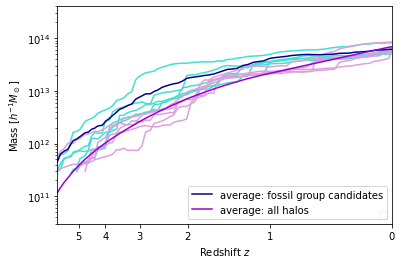

In [45]:
# Function version
fg_idx = binned_fgs[1]
nonfg_idx = target_idx[1]
mbins = [1e13, 5e13, 1e14]
nsamples = 5
ylims = [3*10**10, 4*10**14]
help_func_haccytrees.plot_compare_avgs(forest, fg_idx, nonfg_idx, mbins, xend = 6, ylims = ylims)

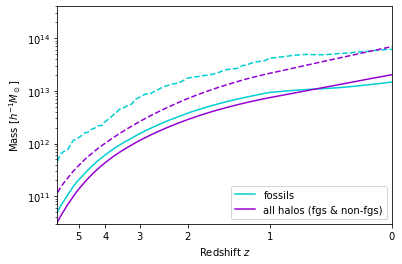

In [52]:
# Try another way
# Function version
fg_idx = binned_fgs[0:2]
nonfg_idx = target_idx[0:2]
mbins = [1e13, 5e13, 1e14]
nsamples = 5
ylims = [3*10**10, 4*10**14]
fig, ax = help_func_haccytrees.plot_compare_avgs_V2(forest, fg_idx, nonfg_idx, mbins, xend = 6, ylims = ylims)
fig.savefig("fg_avg_comp_all.png")

In [51]:
len(target_idx[0])

37079

#### Some other things I learned

In [171]:
x = np.array([[[0, 1], [1, 1], [2, 2]], [[1, 1], [2, 1], [0,1]]])
print(x, "\n")

# sum row by row, across bins
rowsum = x.sum(0)
print(rowsum)
print(rowsum <= 2)
masked = x[:, rowsum <= 2] # But nothing works for x.sum(1)
print(masked, "\n")

# sum rows together, within each bin
rowsum = x.sum(2) # or -1
print(rowsum)
print(rowsum <= 2)
masked = x[rowsum <= 2, :] 
print(masked, "\n")

# sum columns together, within each bin
rowsum = x.sum(1)
print(rowsum)
print(rowsum <= 2)
masked = x[rowsum <= 2, :] # No way to successfully do this?
print(masked)

[[[0 1]
  [1 1]
  [2 2]]

 [[1 1]
  [2 1]
  [0 1]]] 

[[1 2]
 [3 2]
 [2 3]]
[[ True  True]
 [False  True]
 [ True False]]
[[0 1 1 2]
 [1 1 1 0]] 

[[1 2 4]
 [2 3 1]]
[[ True  True False]
 [ True False  True]]
[[0 1]
 [1 1]
 [1 1]
 [0 1]] 

[[3 4]
 [3 3]]
[[False False]
 [False False]]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 2

In [90]:
a = np.array([[1,2,2], [2,1.4,3]])
print(a)
b = a > 1.5
print(b, "\n")
c = (a > 1.5)[:, ::-1]
print(c)
print("Exp")
print((a > 1.5)[::-1, :])

[[1.  2.  2. ]
 [2.  1.4 3. ]]
[[False  True  True]
 [ True False  True]] 

[[ True  True False]
 [ True False  True]]
Exp
[[ True False  True]
 [False  True  True]]


In [125]:
arr = np.array([1,2,3,4, 0, -2, 6, 2.1, 1.8])
np.argwhere(arr > 2)

array([[2],
       [3],
       [6],
       [7]])

### Testing Various Functions

In [124]:
absolute_threshold = True
merger_threshold = 5e12
major_mergers_only = False
mergers, merger_index = help_func_haccytrees.get_mergers(forest, progenitor_array, mainbranch_index, major_mergers_only, merger_threshold)
# Great that this works -- probably never going to use it again

[0. 0. 0. ... 0. 0. 0.]


In [114]:
absolute_threshold = False
mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold)
mask = mainbranch_mergers > 0.3
mainbranch_mergers[~mask] = 0

In [115]:
major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers, threshold = 0.3)
print(major_mergers)
print(major_mergers[major_mergers != 0])

[[0.         0.         0.         ... 0.         0.         0.51567847]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0.39935064 0.71843    0.51567847 ... 0.30067578 0.92411923 0.42694646]


In [120]:
print(len(mainbranch_mergers))
lmms = help_func_haccytrees.get_lmms(mainbranch_mergers, threshold = 0.3) # Another common threshold is 0.3
print(len(lmms))
lmms

23256
23256


array([2.22044605e-16, 4.37433155e+00, 5.77708006e-01, ...,
       1.05521472e+00, 1.54430380e+00, 5.39050536e-01])

In [ ]:
help_func_haccytrees.get_aggregate_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold = False, major_mergers_only = False, merger_threshold = 0.3)
# Do I have a true need for this?

### Major Merger Rates

193417


<ipython-input-166-f0e5fa3cfbbe>:65: RuntimeWarning: invalid value encountered in true_divide
  merger_probability[i] = major_mergers_per_sn / total_halos_per_sn


23256
1736


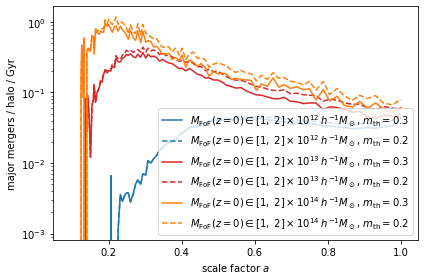

In [166]:
# Define 3 mass-bins
mass_bins = [
    (1e12, 2e12),
    (1e13, 2e13),
    (1e14, 2e14)
]

relative_thresholds = [1/3, 1/4]

# a mask to select all z=0 halos
z0_mask = forest['snapnum'] == 100

# where we will store the merger probability for each mass bin
merger_probability = {} ########## Why this syntax? ##########

for i, mlim in enumerate(mass_bins):
    # creating a target mask for halos at z=0 and in the mass-bin
    target_mask = np.copy(z0_mask)
    target_mask &= (forest['tree_node_mass'] > mlim[0]) 
    target_mask &= (forest['tree_node_mass'] < mlim[1])
    target_idx = forest['halo_index'][target_mask]
    print(len(target_idx))
    
    # Create a matrix of shape (ntargets, nsteps), where each row is the main
    # progenitor branch of a target. It contains the indices to the forest data,
    # and is -1 if the halo does not exist at that time
    mainbranch_index = haccytrees.mergertrees.get_mainbranch_indices(
        forest, simulation='LastJourney', target_index=target_idx
    )
    
    # mask of the matrix elements that are "filled"
    active_mask = mainbranch_index > 0
    
    # For all halos in the matrix, find the main progenitor index and the main merger index
    mainprog_index = haccytrees.mergertrees.get_nth_progenitor_indices(
        forest, progenitor_array, target_index=mainbranch_index[active_mask], n=1
    )
    mainmerger_index = haccytrees.mergertrees.get_nth_progenitor_indices(
        forest, progenitor_array, target_index=mainbranch_index[active_mask], n=2
    )
    
    # Calculate merger ratio at the locations where there are mergers
    # (i.e. where mainmerger_index > 0)
    ###### So we don't make a separate merger_mask, just build that in here ########
    ###### We also don't make a separate matrix of zeros for merger_ratio -- just do a straight division #######
    ###### So, in our other functions, do we need a separate matrix for merger ratio? ########
    ###### actually, a few lines later, we do mess around with active masks too, and also create np.zeros #######
    mainprog_mass   = forest['tree_node_mass'][mainprog_index[mainmerger_index >=0]]
    mainmerger_mass = forest['tree_node_mass'][mainmerger_index[mainmerger_index >= 0]]
    merger_ratio = mainmerger_mass / mainprog_mass
    # Expand it to the "active" part of the matrix
    merger_ratio_active = np.zeros(len(mainprog_index))
    merger_ratio_active[mainmerger_index >= 0] = merger_ratio
    # Expand it to the matrix
    merger_ratio_matrix = np.zeros_like(mainbranch_index, dtype=np.float32)
    merger_ratio_matrix[active_mask] = merger_ratio_active
    
    # The probability for a halo to undergo a major merger at a specific snapshot
    # (along the main progenitor branch)
    total_halos_per_sn = np.sum(active_mask, axis=0)
    major_mergers_per_sn = np.array(
        [np.sum(merger_ratio_matrix > threshold, axis=0) ##### Why axis = 0, and not 1?
            for threshold in relative_thresholds])
    
    merger_probability[i] = major_mergers_per_sn / total_halos_per_sn
    merger_probability[i][:, total_halos_per_sn == 0] = 0   ###### Is this an index, or a mask?
    
    
# Get the scale factors associated with each step (matrix row)
simulation = haccytrees.Simulation.simulations['LastJourney']
scale_factors = simulation.step2a(np.array(simulation.cosmotools_steps))
# Get the time difference between steps in Gyr
lookback_times = simulation.step2lookback(np.array(simulation.cosmotools_steps))
dt = lookback_times[:-1] - lookback_times[1:]

# plotting the major merger probability at every timestep
fig, ax = plt.subplots()
for i, mlim in enumerate(mass_bins):
    for j, rt in enumerate(relative_thresholds):
        # Convert merger rate per snapshot to merger rate per Gyr
        merger_rate = merger_probability[i][j, 1:] / dt
        ax.plot(scale_factors[1:], merger_rate, 
                label=fr"$M_\mathrm{{FoF}}(z=0) \in [1, \; 2] "
                      fr"\times 10^{{{np.log10(mlim[0]):.0f}}} "
                      fr"\; h^{{-1}}M_\odot$, "
                      fr"$m_\mathrm{{th}}={rt:.1f}$",
                color=['tab:blue', 'tab:red', 'tab:orange'][i],
                linestyle=['-', '--'][j])
ax.set(
    yscale='log',
    xlabel='scale factor $a$', 
    ylabel=r'major mergers / halo / Gyr'
)
ax.legend()
fig.tight_layout()

### Random things

In [239]:
z0_mask = forest['snapnum'] == 100
mlim = [1e13, 5e13]
target_mask = z0_mask & (forest['fof_halo_mass'] > mlim[0]) * (forest['fof_halo_mass'] < mlim[1])
target_idx = forest['halo_index'][target_mask]

# this will create a matrix of shape (ntargets, nsteps), where each column
# is the main progenitor branch of a target. It contains the indices to the
# forest data, and is -1 if the halo does not exist at that time
mainbranch_index = haccytrees.mergertrees.get_mainbranch_indices(
    forest, simulation='LastJourney', target_index=target_idx
)

active_mask = mainbranch_index != -1
mainbranch_mass = np.zeros_like(mainbranch_index, dtype=np.float32)
mainbranch_mass[active_mask] = forest['fof_halo_mass'][mainbranch_index[active_mask]]

mainbranch_binned_index.append(mainbranch_index)
mainbranch_binned_masses.append(mainbranch_mass)

# Calculate the alphas
alphas = help_func.calc_mass_growth_rate(mainbranch_binned_masses, main_prog_list)
# Plot them
a = help_func.plot_distrib([alphas], "Mass Growth Rate", r"$\alpha$", n_hist_bins = 20, zoom = True, log = True)

NameError: name 'main_prog_list' is not defined

In [249]:
from numba import autojit, prange

@autojit
def parallel_sum(A):
    sum = 0.0
    for i in prange(A.shape[0]):
        sum += A[i]

    return sum

A = [1, 3, 5]
sum = parallel_sum(A)

ImportError: cannot import name 'autojit' from 'numba' (/home/acossairt/miniconda3/lib/python3.8/site-packages/numba/__init__.py)